In [34]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version reported by torch:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

Torch: 2.6.0+cu124
CUDA available: True
CUDA version reported by torch: 12.4
Device count: 1
Device 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [64]:
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
class SimpleCNN2(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
def train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            train_iter.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_iter.set_postfix(loss=loss.item())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


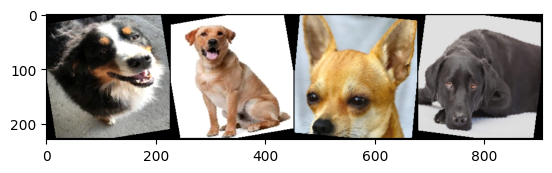

bernese_mountain_dog labrador chihuahua labrador


In [59]:
# Test loader is dog-breed-images
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset

image_path = "dog-breed-images/"


# TRAIN: random augmentations 
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.RandomRotation(degrees=10, fill=0),  # small rotation
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), value='random')
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(image_path)  # no transform here

# 60/10/30 split (train/val/test)
n = len(base_dataset)
train_size = int(0.6 * n)
val_size   = int(0.1 * n)
test_size  = n - train_size - val_size  # ~30%
gen = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = torch.utils.data.random_split(
    base_dataset, [train_size, val_size, test_size], generator=gen
)

# rewrap each split with its own transforms by creating new ImageFolder objects
train_dataset = Subset(datasets.ImageFolder(image_path, transform=train_tfms), train_subset.indices)
val_dataset   = Subset(datasets.ImageFolder(image_path, transform=base_transform),  val_subset.indices)
test_dataset  = Subset(datasets.ImageFolder(image_path, transform=base_transform),  test_subset.indices)

# DataLoaders
cuda = torch.cuda.is_available()
common_loader_kwargs = dict(num_workers=2, pin_memory=cuda, persistent_workers=(2 > 0))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  drop_last=True,  **common_loader_kwargs)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

# If you want to print class names:
classes = datasets.ImageFolder(image_path).classes


# visualize a batch of images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


def test_model(model, test_loader, device):
    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Epoch 1/10: Train Loss: 2.0221, Val Loss: 1.9514


Epoch 2/10: Train Loss: 1.9415, Val Loss: 1.9526


Epoch 3/10: Train Loss: 1.9450, Val Loss: 1.9455


Epoch 4/10: Train Loss: 1.9302, Val Loss: 1.9131


Epoch 5/10: Train Loss: 1.9154, Val Loss: 1.9022


Epoch 6/10: Train Loss: 1.8819, Val Loss: 1.9019


Epoch 7/10: Train Loss: 1.8996, Val Loss: 1.8513


Epoch 8/10: Train Loss: 1.8773, Val Loss: 1.7896


Epoch 9/10: Train Loss: 1.8384, Val Loss: 1.8252


Epoch 10/10: Train Loss: 1.8524, Val Loss: 1.8076


Test Accuracy: 23.59%


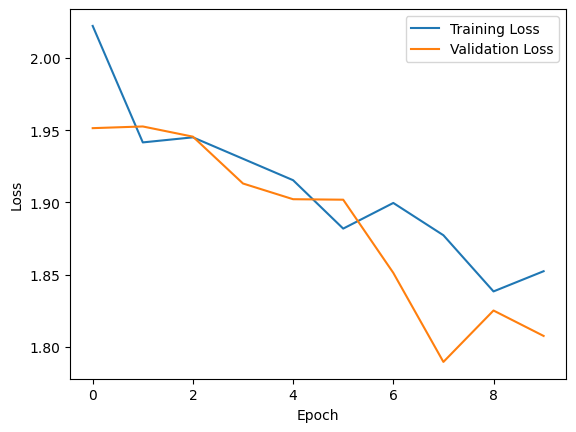

In [67]:

# Define criterion and optimizer
model = SimpleCNN(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10: Train Loss: 2.1601, Val Loss: 1.9670


Epoch 2/10: Train Loss: 1.8844, Val Loss: 1.9368


Epoch 3/10: Train Loss: 1.7976, Val Loss: 1.8351


Epoch 4/10: Train Loss: 1.6781, Val Loss: 1.7261


Epoch 5/10: Train Loss: 1.6109, Val Loss: 1.7421


Epoch 6/10: Train Loss: 1.5283, Val Loss: 1.7569


Epoch 7/10: Train Loss: 1.4547, Val Loss: 1.6709


Epoch 8/10: Train Loss: 1.4592, Val Loss: 1.6686


Epoch 9/10: Train Loss: 1.3594, Val Loss: 1.6239


Epoch 10/10: Train Loss: 1.3044, Val Loss: 1.9898


Test Accuracy: 39.49%


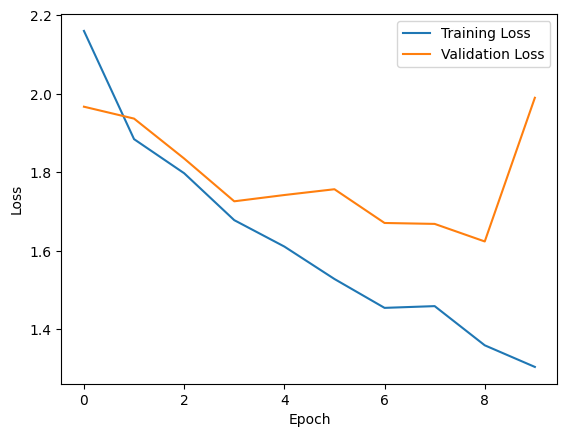

In [68]:
# Same as above, but without dropout

# Define criterion and optimizer
model = SimpleCNN2(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



## Part 2 Task I

To compare the two datasets, first visualize a few sample images from each. Observe aspects such as image resolution, background complexity, dog pose, and annotation quality. Systematic differences may include:

- **Stanford Dogs Dataset**: Typically features higher-resolution images, varied backgrounds, and dogs in natural settings. Images may have more challenging backgrounds and diverse poses.
- **Dog Breed Images Dataset**: May contain more standardized images, sometimes with simpler backgrounds or studio-like settings. The annotation style and cropping may differ.

Briefly document any consistent differences you notice, as these can impact model training and generalization.

## Task 3: ResNet training
a) In this task, we use the ResNet-18 model for the classification of the images in the DBI dataset. To do so, use the ResNet-18 model from PyTorch, modify the input/output layers to match your dataset, and train the model from scratch; i.e., do not use the pre- trained ResNet. Plot the training and validationaccuracy and report the final test results, and compare those with the results of your CNN model.

b) Run the trained model on the entire SDD dataset and report the accuracy. Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10: Train Loss: 2.0977, Val Loss: 8.0436


Epoch 2/10: Train Loss: 1.8097, Val Loss: 2.3069


Epoch 3/10: Train Loss: 1.6852, Val Loss: 1.6618


Epoch 4/10: Train Loss: 1.5336, Val Loss: 1.5626


Epoch 5/10: Train Loss: 1.6234, Val Loss: 1.8725


Epoch 6/10: Train Loss: 1.5090, Val Loss: 1.8078


Epoch 7/10: Train Loss: 1.4159, Val Loss: 1.5934


Epoch 8/10: Train Loss: 1.3551, Val Loss: 1.3813


Epoch 9/10: Train Loss: 1.3799, Val Loss: 1.4826


Epoch 10/10: Train Loss: 1.2326, Val Loss: 1.7717


Test Accuracy: 27.69%


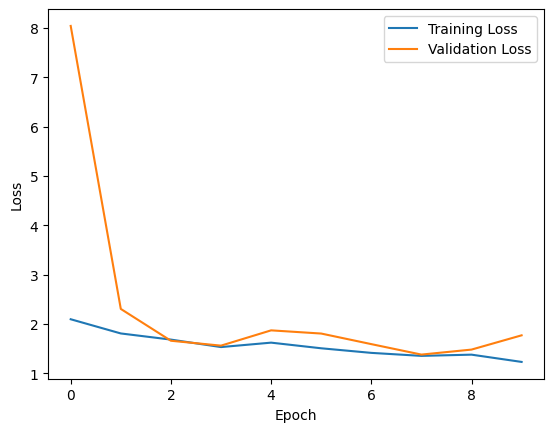

In [69]:
import torchvision.models as models

# Load an untrained ResNet-18 model
resnet18_untrained = models.resnet18(pretrained=False)

# modify the final layer to match the number of classes in your dataset
num_ftrs = resnet18_untrained.fc.in_features
resnet18_untrained.fc = nn.Linear(num_ftrs, len(train_loader.dataset.dataset.classes))

resnet_model = resnet18_untrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 10
train_losses, val_losses = train_validate_cnn(resnet_model, train_loader, val_loader, criterion, optimizer, epochs, device)
test_model(resnet_model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Run the trained ResNet model on the entirety of the Stanford Dog Dataset (SDD)

sdd_path = "stanford-dogs-dataset/images/"
sdd_dataset = datasets.ImageFolder(sdd_path, transform=base_transform)
sdd_loader = DataLoader(sdd_dataset, batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

test_model(resnet_model, sdd_loader, device)

Test Accuracy: 24.41%


# TODO: 
Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

# Task 4: Fine-Tuning on DBI

Fine tune a number of different pre-trained models on the DBI.

# Task 5: Dataset Detection
Train a model that will binary classify which dataset an image belongs to.

# Tracking Comparison
Use a face detection model (such as MediaPipe Face Detection, OpenCV’s DNN face detector, or MTCNN) to detect the face in the first frame of the video.

Initialize three different face trackers with the detected bounding box:

• CSRT Tracker or KCF Tracker (both have OpenCV implementation)

• Two other trackers: research and select two additional trackers of your choosing. 

Try to choose good new models, e.g. by looking up leaderboards. Note that we are looking for tracking models, not face detection models.
If you wish, instead of CSRT or KCF you can also use another tracker of your choosing.

## Performance Analysis:
• Track the face through all frames of the video using each of the three trackers.

• For ground truth comparison, run your face detection model on every 5th frame to establish reference bounding boxes. For this assignment, we’re going to assume that the face detection model is perfect and gives us the ground truth location of the face.

• Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.

• (5 marks) Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.

In [ ]:
import cv2 
import numpy as np

# initialize cv2 neural network face detector
net = cv2.dnn.readNetFromCaffe("models/deploy.prototxt.txt", "models/res10_300x300_ssd_iter_140000.caffemodel")

# create function to detect faces in an image
def detect_faces(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    faces = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append((startX, startY, endX, endY))
    return faces

def to_xywh(box_xyxy):
    x1, y1, x2, y2 = box_xyxy
    return (int(x1), int(y1), int(x2 - x1), int(y2 - y1))

# break video into array of frames 
def video_to_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

frames = video_to_frames("TheOffice.mp4") # let's try to use a different video (of my own face) to reduce track seduction

# get first frame and detect face
first_face_bbox = to_xywh(detect_faces(frames[0])[0])
gt = [] # ground truth boxes 
gt.append([0, first_face_bbox]) # frame number, (x, y, w, h)    

tracker = cv2.TrackerCSRT_create() # Initialize the CSRT tracker
tracker.init(frames[0], first_face_bbox) # tracker wants (x, y, w, h)

goturn_tracker = cv2.TrackerGOTURN.create() # initialize the GOTURN tracker
goturn_tracker.init(frames[0], first_face_bbox)

mosse_tracker = cv2.legacy.TrackerMOSSE_create()
mosse_tracker.init(frames[0], first_face_bbox)

tracks = {"CRST": [],
          "GOTURN": [],
          "MOSSE": []}

# loop through all frames and track the face
for i, frame in enumerate(frames):
    # Update the CRST tracker and get the new bounding box
    success, bbox = tracker.update(frame)
    goturn_success, goturn_bbox = goturn_tracker.update(frame)
    mosse_success, mosse_bbox = mosse_tracker.update(frame)

    if success:
        # Draw the bounding box on the frame
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "CRST Tracking", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        tracks["CRST"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        # Tracking failed
        cv2.putText(frame, "CRST Tracking failed!", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    
    if goturn_success:
        x, y, w, h = [int(v) for v in goturn_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, "GOTURN Tracking", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
        tracks["GOTURN"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        cv2.putText(frame, "GOTURN Tracking failed!", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)


    if mosse_success:
        x, y, w, h = [int(v) for v in mosse_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        cv2.putText(frame, "MOSSE Tracking", (100, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
        tracks["MOSSE"].append([i, (x, y, w, h)]) # store frame number and bbox

    # detect face for every fifth frame as ground truth
    if i % 5 == 0 and i != 0:
        faces = detect_faces(frame)
        if len(faces) > 0:
            x, y, w, h = to_xywh(faces[0])
            gt.append([i, to_xywh(faces[0])]) # store frame number and bbox
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2) # red box for ground truth
            cv2.putText(frame, "Ground Truth", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            

    # Display the frame
    cv2.imshow("Tracking", frame)
    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # press q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

print("Ground Truth:", gt)
print("Tracks:", tracks)

tracks['ground_truth'] = gt

# save tracks dict as json
import json
with open("tracks.json", "w") as f:
    json.dump(tracks, f)


Ground Truth: [[0, (392, 60, 77, 117)], [5, (391, 58, 82, 120)], [10, (392, 57, 82, 117)], [15, (390, 57, 87, 118)], [20, (391, 61, 81, 117)], [25, (392, 68, 88, 122)], [30, (391, 75, 85, 114)], [35, (390, 65, 82, 117)], [40, (386, 67, 79, 115)], [50, (413, 70, 82, 115)], [55, (445, 72, 70, 124)], [60, (445, 94, 78, 108)], [65, (429, 94, 80, 120)], [70, (393, 93, 76, 106)], [75, (357, 71, 81, 116)], [80, (367, 86, 76, 118)], [85, (410, 79, 71, 116)], [205, (2, 114, 104, 101)], [270, (456, 215, 36, 44)], [275, (449, 216, 43, 47)], [280, (447, 203, 46, 46)], [285, (456, 206, 45, 49)]]
Tracks: {'CRST': [[0, (392, 60, 77, 117)], [1, (392, 60, 77, 117)], [2, (392, 60, 77, 117)], [3, (392, 59, 77, 117)], [4, (393, 61, 75, 115)], [5, (392, 59, 77, 117)], [6, (392, 59, 77, 117)], [7, (392, 59, 77, 117)], [8, (393, 60, 75, 115)], [9, (392, 58, 77, 117)], [10, (393, 60, 75, 115)], [11, (392, 58, 77, 117)], [12, (392, 58, 77, 117)], [13, (392, 58, 77, 117)], [14, (392, 58, 77, 117)], [15, (392, 5

Average IoU for CRST: 0.6877
Average IoU for GOTURN: 0.4648
Average IoU for MOSSE: 0.6894


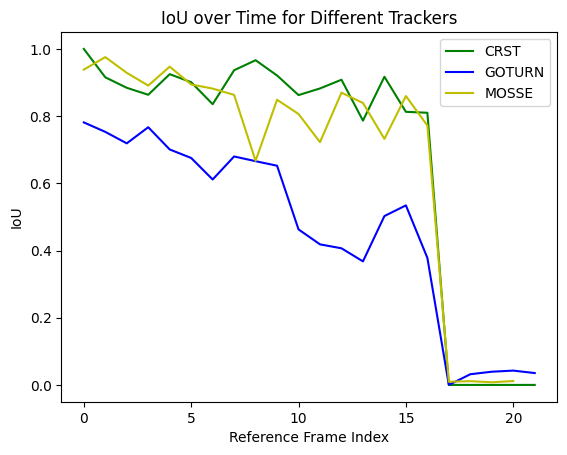

In [33]:
# Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.
ious = {"CRST": [], "GOTURN": [], "MOSSE": []}
def bb_intersection_over_union(boxA, boxB):
    # boxes are stored as (x,y,w,h)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

for method in ["CRST", "GOTURN", "MOSSE"]:
    for gt_frame, gt_box in gt:
        # find the corresponding box in tracks
        pred_boxes = [box for frame, box in tracks[method] if frame == gt_frame]
        if len(pred_boxes) > 0:
            pred_box = pred_boxes[0]
            iou = bb_intersection_over_union(gt_box, pred_box)
            ious[method].append(iou)
    if len(ious[method]) > 0:
        avg_iou = sum(ious[method]) / len(ious[method])
    else:
        avg_iou = 0
    print(f"Average IoU for {method}: {avg_iou:.4f}")

# Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.
import matplotlib.pyplot as plt
for method, color in zip(["CRST", "GOTURN", "MOSSE"], ['g', 'b', 'y']):
    plt.plot(range(len(ious[method])), ious[method], label=method, color=color)

plt.xlabel("Reference Frame Index")
plt.ylabel("IoU")
plt.title("IoU over Time for Different Trackers")
plt.legend()
plt.savefig("iou_comparison.png")# save plot as png


plt.show()



# Qualitative Analysis 
Select two frames, one where the tracking should be very easy, and one where it should be more difficult.